# TUTORIAL: Sound classification

## Introduction

The aim of this Notebook is to use **AI NOTEBOOKS** product to train a model to classify sounds in *.wav* format.

#### USE CASE:  [Best of Watkins Marine Mammal Sound Database](https://www.kaggle.com/shreyj1729/best-of-watkins-marine-mammal-sound-database/version/3)

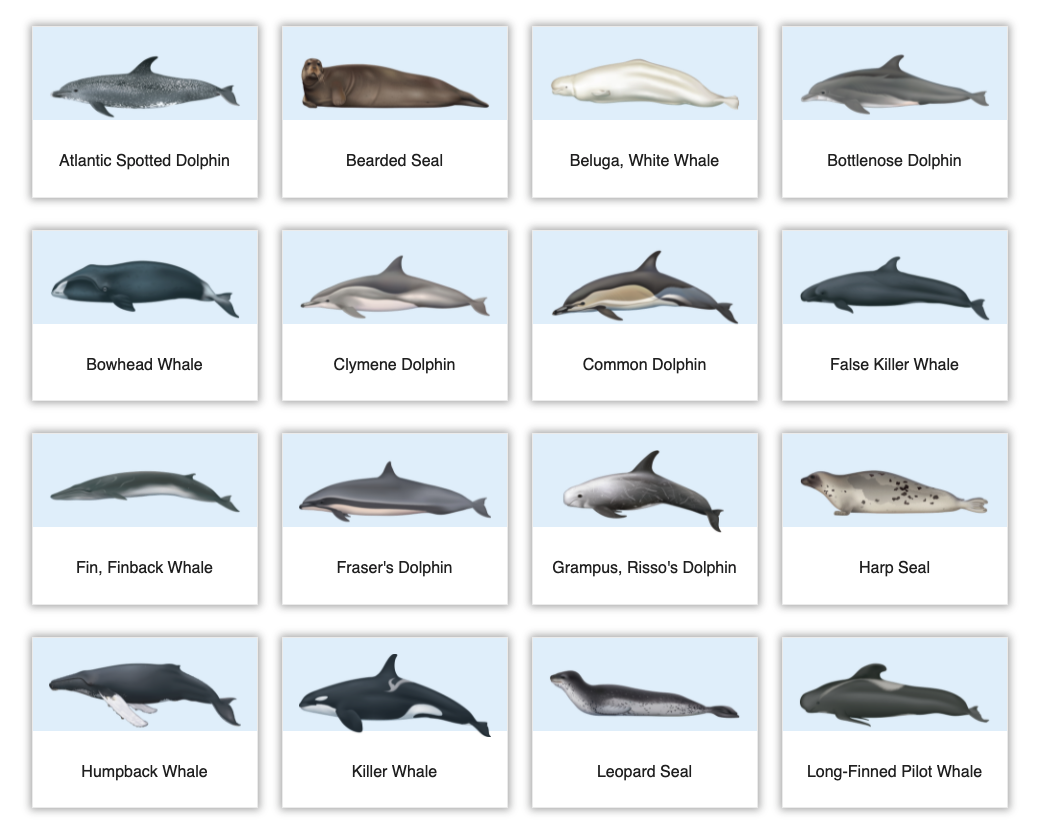

This dataset is composed of 55 different folders corresponding to the marine mammals. In each folder are stored several sound files of each animal in *.wav* format.

You can get more information on this dataset on this [website](https://cis.whoi.edu/science/B/whalesounds/index.cfm).

The data is then as follows:

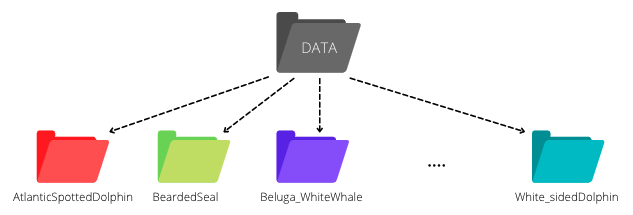

⚠️ For this example, we choose only the first 45 classes (or folders)

To classify sounds, we will go through different steps. 

## Code

- Install and import dependencies
- Observe data
- Data preprocess
- Separate data for training
- Define the neural network model
- Train model
- Evaluate results

### Step 1 - Import dependencies

Before starting, import following dependencies.

In [1]:
import librosa
import librosa.display as lplt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import IPython

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Keras / TensorFlow
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential

### Step 2 - Observe data

You can start by looking at your data by displaying different parameters using the librosa library.

First, you can do a test on a file.

In [2]:
# select a random sound
test_sound = "data/AtlanticSpottedDolphin/61025001.wav"

- Loads and decodes the audio

In [3]:
data, sr = librosa.load(test_sound)
print(type(data), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [4]:
librosa.load(test_sound ,sr = 45600)

(array([-0.0739522 , -0.06588229, -0.06673266, ...,  0.03021295,
         0.05592792,  0.        ], dtype=float32),
 45600)

- Play audio in the notebook

In [5]:
IPython.display.Audio(data, rate = sr)

- **Waveforms** (visual representations of sound as time on the x-axis and amplitude on the y-axis)

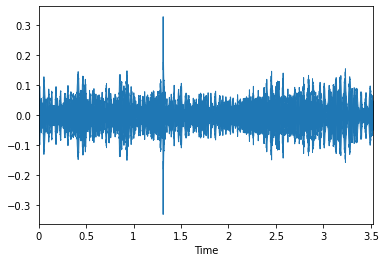

In [6]:
plt.show(librosa.display.waveplot(data))

- **Spectrograms**

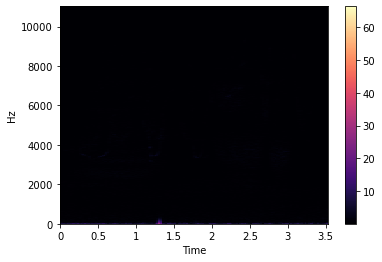

In [8]:
stft = librosa.stft(data)
plt.colorbar(librosa.display.specshow(stft, sr = sr, x_axis = 'time', y_axis = 'hz'))

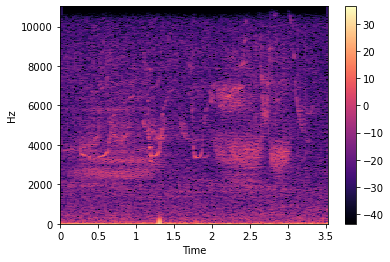

In [9]:
stft_db = librosa.amplitude_to_db(abs(stft))
plt.colorbar(librosa.display.specshow(stft_db, sr = sr, x_axis = 'time', y_axis = 'hz'))

- **Spectral Rolloff**

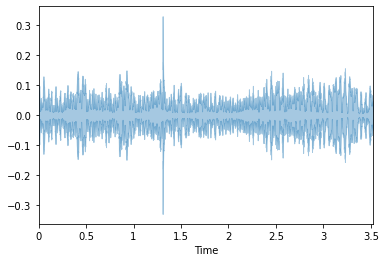

In [10]:
spectral_rolloff = librosa.feature.spectral_rolloff(data + 0.01, sr = sr)[0]
plt.show(librosa.display.waveplot(data, sr = sr, alpha = 0.4))

- **Chroma Feature**

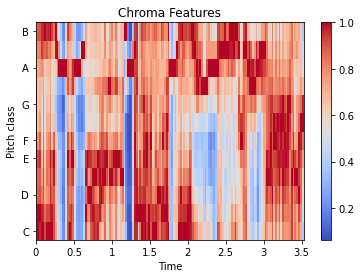

In [11]:
chroma = librosa.feature.chroma_stft(data, sr = sr)
lplt.specshow(chroma, sr = sr, x_axis = "time" ,y_axis = "chroma", cmap = "coolwarm")
plt.colorbar()
plt.title("Chroma Features")
plt.show()

- **Zero Crossing Rate**

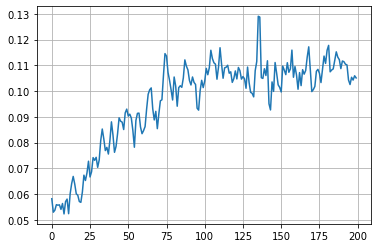

In [12]:
start = 1000
end = 1200
plt.plot(data[start:end])
plt.grid()

### Step 3 - Data preprocess

To train your model, you have to convert the *.wav* into a *.csv* file.

In [13]:
# define columns name
header = "filename length chroma_stft_mean chroma_stft_var rms_mean rms_var spectral_centroid_mean spectral_centroid_var \
    spectral_bandwidth_mean spectral_bandwidth_var rolloff_mean rolloff_var zero_crossing_rate_mean zero_crossing_rate_var \
    harmony_mean harmony_var perceptr_mean perceptr_var tempo mfcc1_mean mfcc1_var mfcc2_mean mfcc2_var mfcc3_mean mfcc3_var \
    mfcc4_mean mfcc4_var label".split()

In [ ]:
file = open('data.csv', 'w', newline = '')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

# character string of marine mammals (45)
marine_mammals = "AtlanticSpottedDolphin BeardedSeal Beluga_WhiteWhale BlueWhale BottlenoseDolphin Boutu_AmazonRiverDolphin BowheadWhale \
    ClymeneDolphin Commerson'sDolphin CommonDolphin Dall'sPorpoise DuskyDolphin FalseKillerWhale Fin_FinbackWhale FinlessPorpoise \
    Fraser'sDolphin Grampus_Risso'sDolphin GraySeal GrayWhale HarborPorpoise HarbourSeal HarpSeal Heaviside'sDolphin HoodedSeal \
    HumpbackWhale IrawaddyDolphin JuanFernandezFurSeal KillerWhale LeopardSeal Long_FinnedPilotWhale LongBeaked(Pacific)CommonDolphin \
    MelonHeadedWhale MinkeWhale Narwhal NewZealandFurSeal NorthernRightWhale PantropicalSpottedDolphin RibbonSeal RingedSeal RossSeal \
    Rough_ToothedDolphin SeaOtter Short_Finned(Pacific)PilotWhale SouthernRightWhale SpermWhale".split()

# transform each .wav file into a .csv row
for animal in marine_mammals:
    for filename in os.listdir(f"/workspace/data/{animal}/"):
        sound_name = f"/workspace/data/{animal}/{filename}"
        y, sr = librosa.load(sound_name, mono = True, duration = 30)
        chroma_stft = librosa.feature.chroma_stft(y = y, sr = sr)
        rmse = librosa.feature.rms(y = y)
        spec_cent = librosa.feature.spectral_centroid(y = y, sr = sr)
        spec_bw = librosa.feature.spectral_bandwidth(y = y, sr = sr)
        rolloff = librosa.feature.spectral_rolloff(y = y, sr = sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y = y, sr = sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
     
        for e in mfcc:
            to_append += f' {np.mean(e)}'
            
        to_append += f' {animal}'
        file = open('data.csv', 'a', newline = '')
        
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [15]:
# display data.csv 
%cd /workspace/
df = pd.read_csv('data.csv')
df.head()

/workspace


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,label
0,6102603E.wav,0.426664,0.042434,5157.104325,3101.100191,8617.587891,0.356964,-241.481033,24.920166,48.238968,...,13.670743,-0.705876,12.712521,1.321301,10.524447,0.343317,6.712308,0.371731,1.841404,AtlanticSpottedDolphin
1,61026030.wav,0.434773,0.053204,5594.399169,2860.406861,8655.933556,0.434289,-228.107635,-4.825935,60.204544,...,11.302414,2.397469,13.868607,-2.265396,11.323673,0.582180,6.923624,-2.080763,1.947379,AtlanticSpottedDolphin
2,61026048.wav,0.432415,0.042047,5135.238139,2982.555668,8378.181032,0.365667,-244.113342,12.709079,48.617630,...,15.568404,-2.544822,10.559988,-0.473371,8.464706,0.382612,6.677320,2.163096,3.520124,AtlanticSpottedDolphin
3,6102603I.wav,0.438314,0.076127,5803.472083,3099.706089,9038.656456,0.414833,-198.311844,0.518129,47.096676,...,15.731695,0.987929,16.382414,-0.967779,8.810925,1.867840,9.033828,2.434472,3.793100,AtlanticSpottedDolphin
4,61026047.wav,0.416906,0.081022,5043.428899,2982.812198,8271.866648,0.322625,-234.926605,12.705063,54.443558,...,15.146926,1.311773,13.756646,-0.811321,8.872554,3.451088,6.508763,-0.489402,4.719871,AtlanticSpottedDolphin


In [16]:
# dataframe shape
df.shape

(12565, 28)

In [17]:
# dataframe types
df.dtypes

filename                    object
length                     float64
chroma_stft_mean           float64
chroma_stft_var            float64
rms_mean                   float64
rms_var                    float64
spectral_centroid_mean     float64
spectral_centroid_var      float64
spectral_bandwidth_mean    float64
spectral_bandwidth_var     float64
rolloff_mean               float64
rolloff_var                float64
zero_crossing_rate_mean    float64
zero_crossing_rate_var     float64
harmony_mean               float64
harmony_var                float64
perceptr_mean              float64
perceptr_var               float64
tempo                      float64
mfcc1_mean                 float64
mfcc1_var                  float64
mfcc2_mean                 float64
mfcc2_var                  float64
mfcc3_mean                 float64
mfcc3_var                  float64
mfcc4_mean                 float64
mfcc4_var                  float64
label                       object
dtype: object

### Step 4 - Separate data for training

- Output:

In [18]:
# y = labels (the last column)
class_list = df.iloc[:,-1]
converter = LabelEncoder()
y = converter.fit_transform(class_list)

In [19]:
# labels -> class 0 to 44 
print("y :", y)

y : [ 0  0  0 ... 44 44 44]


- Inputs:

In [20]:
# inputs of the neural network
print("x :", df.iloc[:,:-1])

x :            filename    length  chroma_stft_mean  chroma_stft_var     rms_mean  \
0      6102603E.wav  0.426664          0.042434      5157.104325  3101.100191   
1      61026030.wav  0.434773          0.053204      5594.399169  2860.406861   
2      61026048.wav  0.432415          0.042047      5135.238139  2982.555668   
3      6102603I.wav  0.438314          0.076127      5803.472083  3099.706089   
4      61026047.wav  0.416906          0.081022      5043.428899  2982.812198   
...             ...       ...               ...              ...          ...   
12560  87009006.wav  0.692880          0.042129      5265.743047  2693.269110   
12561  84018003.wav  0.703688          0.084945      2696.827277  2899.529652   
12562  7702801C.wav  0.385056          0.083000      4612.468439  2910.640538   
12563  90009004.wav  0.491667          0.061300      1823.044862  2408.158429   
12564  7500501S.wav  0.785796          0.010482      3266.896607  3269.899564   

           rms_var  spe

In [21]:
fit = StandardScaler()

# input: from column 1 to 26
X = fit.fit_transform(np.array(df.iloc[:, 1:26], dtype=float))
X

array([[-0.71758759,  0.20419758,  1.17840861, ...,  0.27289075,
         0.59678504,  0.59680033],
       [-0.66140594,  0.48716815,  1.44344394, ...,  0.31793616,
         0.6360472 ,  0.11020783],
       [-0.67774188,  0.19402336,  1.16515597, ...,  0.28030108,
         0.59028425,  0.95222009],
       ...,
       [-1.00584499,  1.27000953,  0.84831611, ...,  0.18362884,
         0.55786759, -0.3320992 ],
       [-0.26724693,  0.69987104, -0.84229563, ...,  0.48437403,
         0.42982227,  0.82545802],
       [ 1.77048234, -0.63530507,  0.03279294, ...,  0.3768085 ,
         0.70826513,  0.53040824]])

- Split dataset for training:

In [22]:
# split dataset for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

### Step 5 - Define the neural network model

In [23]:
# build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation = 'relu', input_shape = (X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(256, activation = 'relu'),
    keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(45, activation = 'softmax'),
])

# display the model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               13312     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8

### Step 6 - Train model

In [24]:
def trainModel(model,epochs, optimizer):
    batch_size = 128
    model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
    return model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, batch_size = batch_size)

In [25]:
# launch training
model_history = trainModel(model = model, epochs = 300, optimizer = 'adam')

Epoch 1/300
79/79 [==============================] - 2s 13ms/step - loss: 2.8959 - accuracy: 0.2963 - val_loss: 1.2510 - val_accuracy: 0.6482
Epoch 2/300
79/79 [==============================] - 0s 6ms/step - loss: 1.3188 - accuracy: 0.6292 - val_loss: 0.8757 - val_accuracy: 0.7616
Epoch 3/300
79/79 [==============================] - 1s 6ms/step - loss: 1.0009 - accuracy: 0.7109 - val_loss: 0.6880 - val_accuracy: 0.8078
Epoch 4/300
79/79 [==============================] - 0s 6ms/step - loss: 0.7975 - accuracy: 0.7615 - val_loss: 0.5757 - val_accuracy: 0.8321
Epoch 5/300
79/79 [==============================] - 0s 6ms/step - loss: 0.7024 - accuracy: 0.8025 - val_loss: 0.5202 - val_accuracy: 0.8524
Epoch 6/300
79/79 [==============================] - 0s 6ms/step - loss: 0.6107 - accuracy: 0.8272 - val_loss: 0.4768 - val_accuracy: 0.8623
Epoch 7/300
79/79 [==============================] - 0s 6ms/step - loss: 0.5445 - accuracy: 0.8406 - val_loss: 0.4417 - val_accuracy: 0.8703
Epoch 8/300


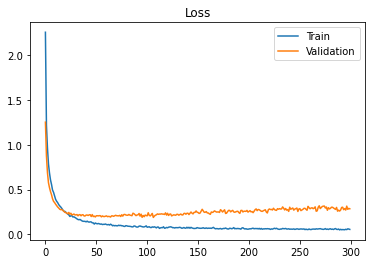

In [26]:
# loss curves
loss_train_curve = model_history.history["loss"]
loss_val_curve = model_history.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(loss_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.show()

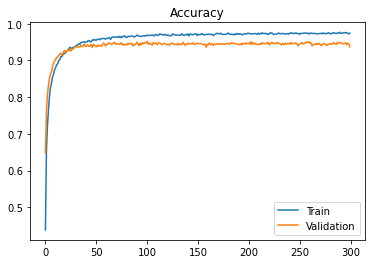

In [27]:
# accuracy curves
acc_train_curve = model_history.history["accuracy"]
acc_val_curve = model_history.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Train")
plt.plot(acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.show()

### Step 7 -  Evaluate results

In [28]:
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size = 128)
print("The test loss is: ", test_loss)
print("The best accuracy is: ", test_acc*100)

20/20 [==============================] - 0s 3ms/step - loss: 0.2854 - accuracy: 0.9371
The test loss is:  0.2853870093822479
The best accuracy is:  93.71269345283508


## Conclusion

The model has been trained on 300 epochs in few minutes with one GPU.

The performance results on the Best of Watkins Marine Mammal Sound Database are as follows after 300 epochs:

**LOSS:**

- validation loss: 0.2854
- loss: 0.0519

**ACCURACY:**

- validation accuracy: 0.9371
- accuracy: 0.9784